In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.lines as mlines
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.anova import anova_lm

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import os
import re
import warnings
import shap

In [2]:
# df here stands for exactly the same as it does in file "01", "02" and "03";
df = pd.read_csv("Raw Data.csv") # The name of participants have been removed right after the experiment.
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.isnull().sum()

age              0
gender           0
SPS              0
FA1              0
FA2              0
FA3              0
FA4              0
RAT              0
BT               0
CSE              0
Group            0
Stage1           0
Stage2           0
Num              0
Stage2_Stage1    0
dtype: int64

In [3]:
df.describe()

,age,gender,SPS,FA1,FA2,FA3,FA4,RAT,BT,CSE,Group,Stage1,Stage2,Num,Stage2_Stage1
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,19.901478,1.773399,101.049261,5.201970,8.285714,12.142857,9.192118,6.078818,4.901478,27.162562,0.507389,13.487685,21.334975,108.931034,7.847291
std,1.210575,0.419667,11.640980,3.329079,4.915841,6.703353,4.110785,2.247924,2.036826,6.612183,0.501181,7.227121,9.768413,62.101683,8.050050
min,18.000000,1.000000,65.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,7.000000,0.000000,3.000000,5.000000,1.000000,-17.000000
25%,19.000000,2.000000,94.000000,3.000000,5.000000,7.000000,6.000000,5.000000,3.000000,23.000000,0.000000,8.000000,14.000000,55.500000,2.000000
50%,20.000000,2.000000,102.000000,4.000000,7.000000,11.000000,9.000000,6.000000,5.000000,28.000000,1.000000,12.000000,19.000000,109.000000,7.000000
75%,21.000000,2.000000,109.000000,7.000000,11.000000,15.500000,11.500000,8.000000,6.000000,32.000000,1.000000,17.000000,28.000000,161.500000,13.000000
max,22.000000,2.000000,128.000000,18.000000,23.000000,34.000000,22.000000,11.000000,10.000000,42.000000,1.000000,37.000000,49.000000,216.000000,35.000000


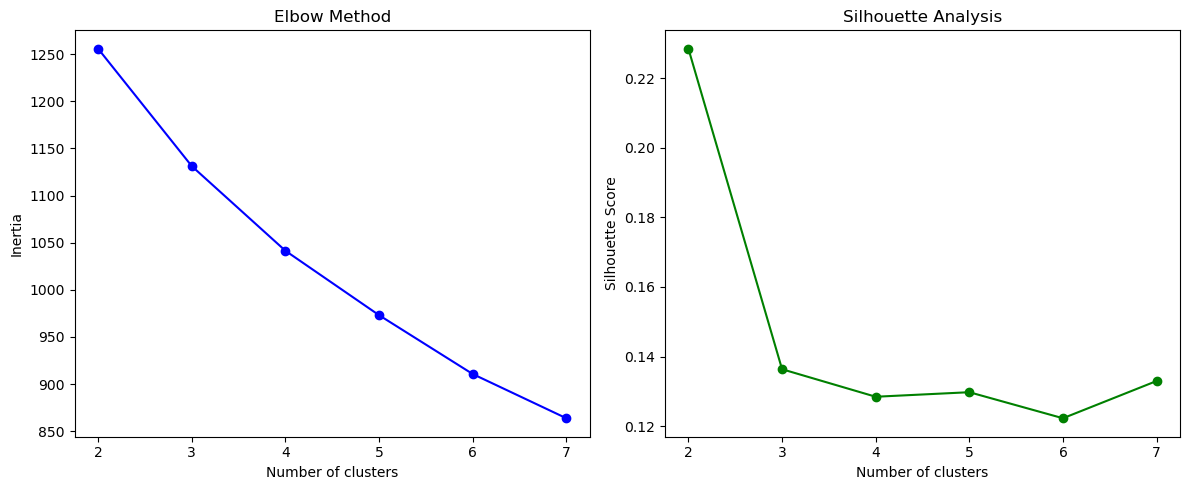

Cluster centers (mean values per feature):
                SPS       FA1        FA2        FA3        FA4       RAT  \
Cluster                                                                    
0         89.898305  3.644068   5.508475   9.186441   7.372881  5.220339   
1        107.253165  3.886076   6.582278   8.835443   7.531646  6.898734   
2        103.630769  8.215385  12.876923  18.846154  12.861538  5.861538   

               BT        CSE  
Cluster                       
0        5.508475  28.406780  
1        3.949367  24.189873  
2        5.507692  29.646154  


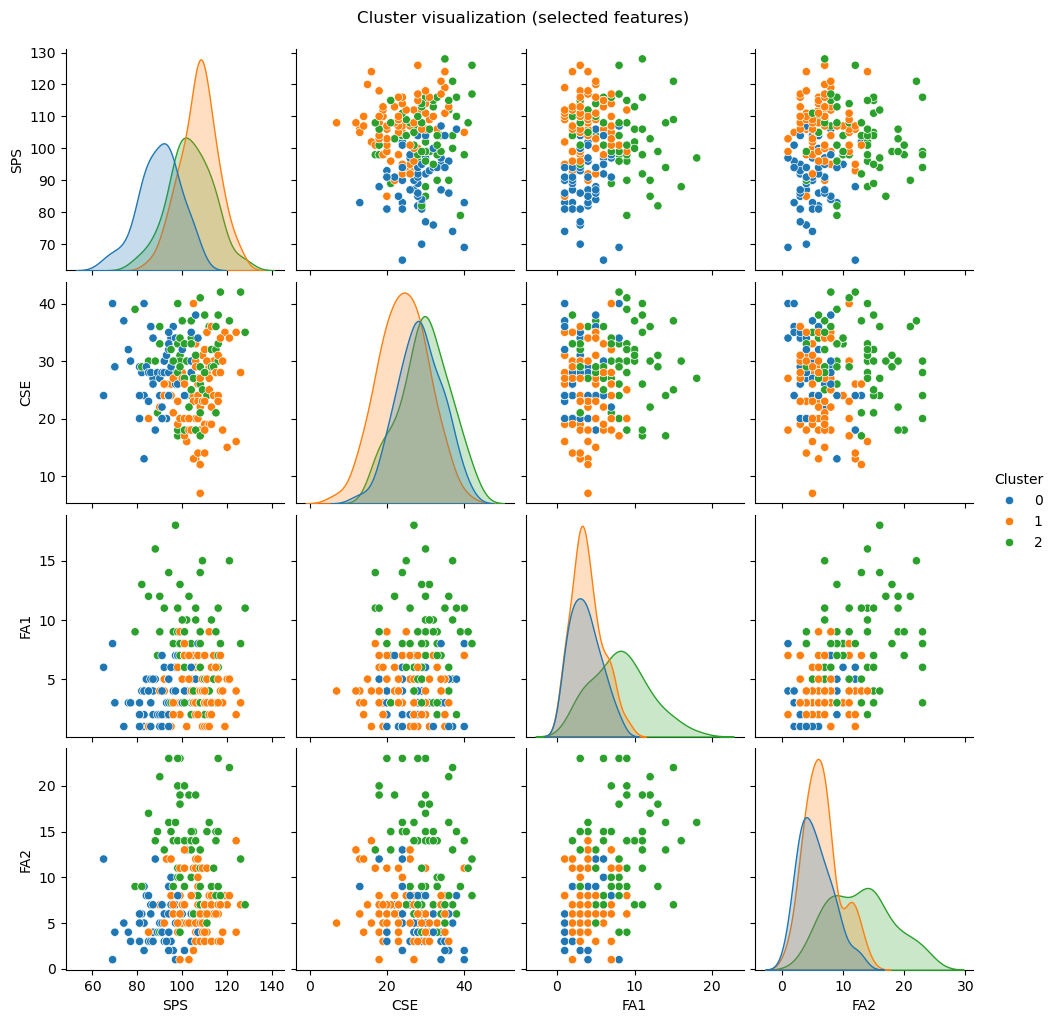

In [4]:
# -------------------------
# Step 0: Imports and environment setup
# -------------------------
import os
import warnings

# -------------------------
# Windows-specific settings to avoid warnings
# -------------------------
os.environ["OMP_NUM_THREADS"] = "1"      
os.environ["LOKY_MAX_CPU_COUNT"] = "4"    

warnings.filterwarnings("ignore")     

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -------------------------
# Step 1: Select features for clustering
# -------------------------
cluster_features = ['SPS', 'FA1', 'FA2', 'FA3', 'FA4', 'RAT', 'BT', 'CSE']

df_cluster = df.dropna(subset=cluster_features).copy()
X = df_cluster[cluster_features]

# -------------------------
# Step 2: Standardize features
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# Step 3: Determine optimal number of clusters (Elbow + Silhouette)
# -------------------------
inertia = []
silhouette = []
K_range = range(2, 8)  # try 2-7 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'o-', color='green')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.show()

# -------------------------
# Step 4: Fit K-Means with chosen k
# -------------------------
optimal_k = 3  # example, choose based on Elbow/Silhouette results
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df_cluster['Cluster'] = cluster_labels

# -------------------------
# Step 5: Analyze cluster characteristics
# -------------------------
cluster_summary = df_cluster.groupby('Cluster')[cluster_features].mean()
print("Cluster centers (mean values per feature):")
print(cluster_summary)

# -------------------------
# Step 6: Visualization
# -------------------------
# Pairplot colored by cluster (select a few features for clarity)
sns.pairplot(df_cluster, vars=['SPS','CSE','FA1','FA2'], hue='Cluster', palette='tab10')
plt.suptitle("Cluster visualization (selected features)", y=1.02)
plt.show()


### Unsupervised Clustering Interpretation

After performing K-Means clustering on participants using SPS, Stage1 (FA1 & FA2) and CSE scores, three distinct clusters were identified:

1. **Orange Cluster**  
   - Low SPS scores.  
   - Low Stage1 creativity scores.  
   - This group may represent low sensitivity and generally lower creative performance under both baseline and stress conditions.

2. **Green Cluster**  
   - Moderate to high SPS scores, noticeably higher than the orange cluster.  
   - Stage1 creativity scores are similar to the orange cluster.  
   - High sensitivity does not correspond to higher creative performance in this group.

3. **Blue Cluster**  
   - Stage1 creativity scores are significantly higher than the other two clusters.  
   - SPS scores are not substantially different from the other clusters.  
   - This cluster may represent participants with high creative performance regardless of sensitivity levels.

**Additional Observation:**  
- CSE (creative self-efficacy) does not show clear differentiation across the three clusters, suggesting it may not strongly contribute to these emergent subtypes.

**Implications:**  
- Sensory processing sensitivity (SPS) alone is not a reliable predictor of creativity change under stress.  
- There exists a subset of participants (blue cluster) whose creativity is consistently high regardless of sensitivity, indicating other underlying factors may support resilience and creative performance.


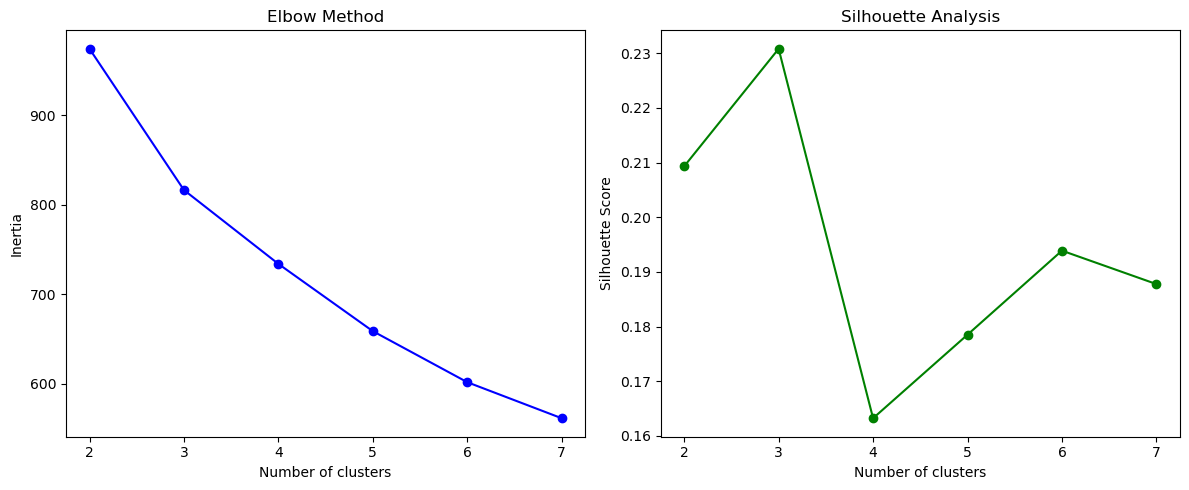

Cluster centers (mean values per feature including gender and age):
                SPS     Stage1     Stage2        CSE    gender        age
Cluster                                                                  
0         98.000000  12.093023  18.813953  28.325581  1.000000  20.139535
1        100.953271  10.028037  16.747664  25.934579  2.000000  19.654206
2        103.716981  21.603774  32.641509  28.698113  1.943396  20.207547

Gender distribution per cluster:
gender    1.0    2.0
Cluster             
0        43.0    NaN
1         NaN  107.0
2         3.0   50.0


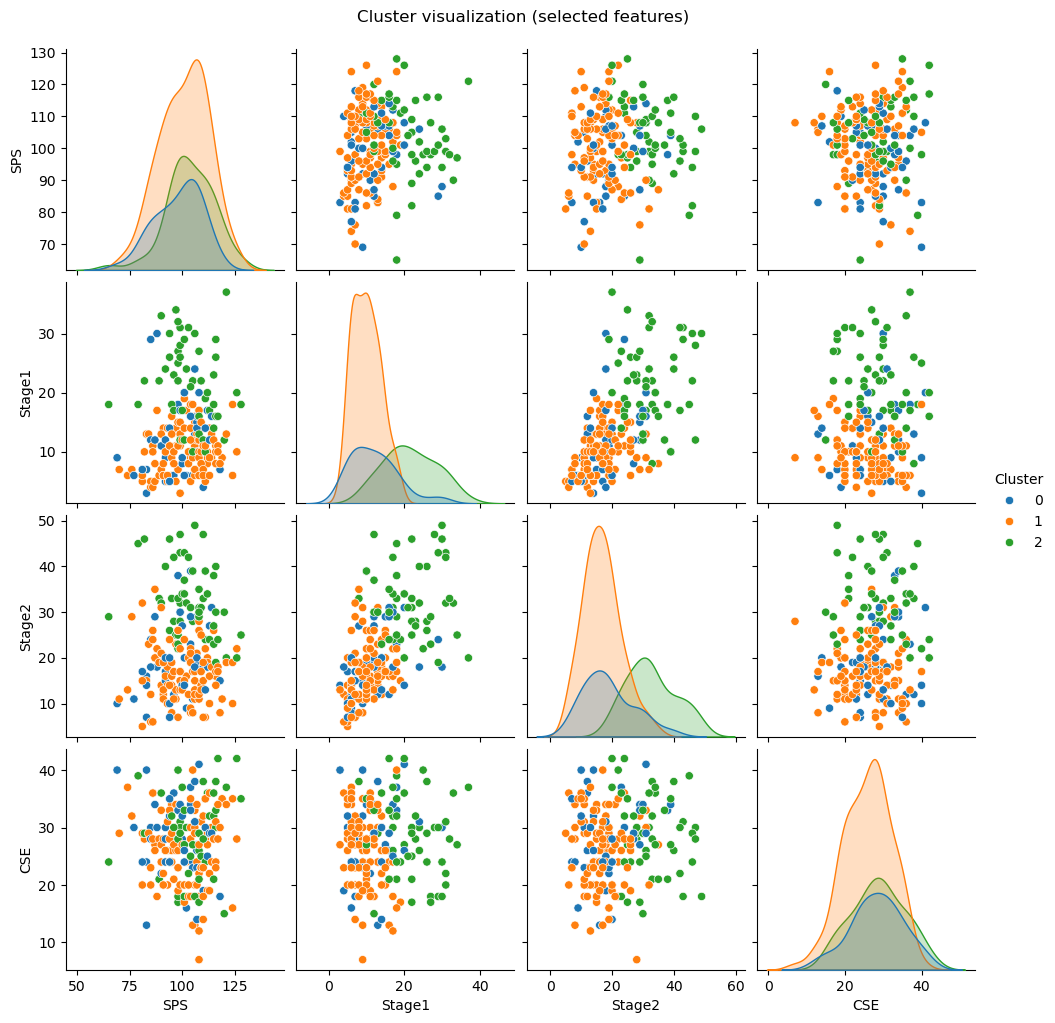

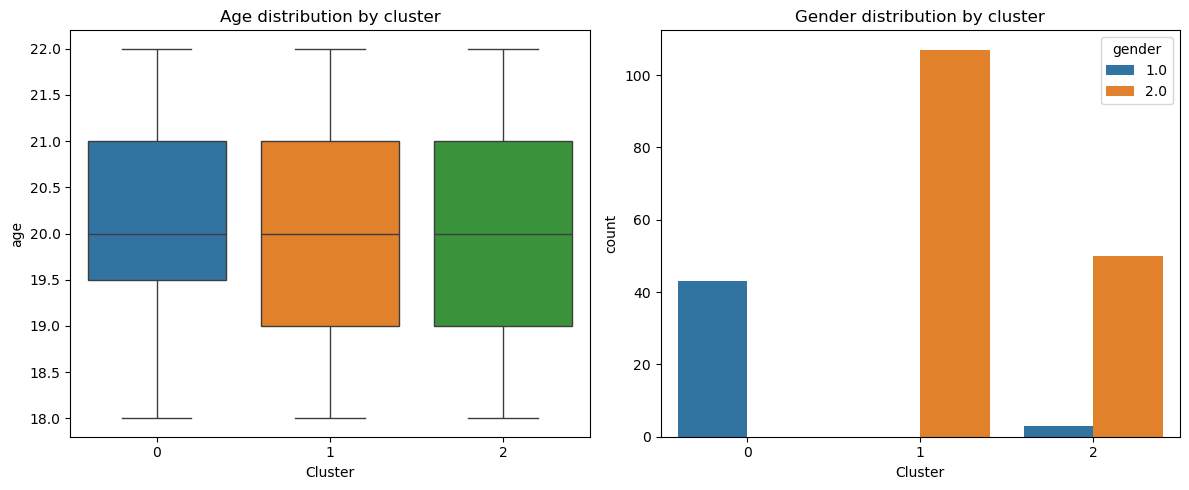

In [5]:
# -------------------------
# Step 1: Select features for clustering (including gender and age)
# -------------------------
cluster_features = ['SPS', 'Stage1', 'Stage2', 'CSE', 'gender', 'age']

df_cluster = df.dropna(subset=cluster_features).copy()
X = df_cluster[cluster_features]

# -------------------------
# Step 2: Standardize features
# -------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------
# Step 3: Determine optimal number of clusters (Elbow + Silhouette)
# -------------------------
inertia = []
silhouette = []
K_range = range(2, 8)  # try 2-7 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

# Plot Elbow and Silhouette
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'o-', color='green')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.show()

# -------------------------
# Step 4: Fit K-Means with chosen k
# -------------------------
optimal_k = 3  # example, choose based on Elbow/Silhouette results
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
df_cluster['Cluster'] = cluster_labels

# -------------------------
# Step 5: Analyze cluster characteristics
# -------------------------
cluster_summary = df_cluster.groupby('Cluster')[cluster_features].mean()
print("Cluster centers (mean values per feature including gender and age):")
print(cluster_summary)

# Optional: Count of each gender per cluster
gender_counts = df_cluster.groupby('Cluster')['gender'].value_counts().unstack()
print("\nGender distribution per cluster:")
print(gender_counts)

# -------------------------
# Step 6: Visualization
# -------------------------
# Pairplot colored by cluster (select key features)
sns.pairplot(df_cluster, vars=['SPS','Stage1','Stage2','CSE'], hue='Cluster', palette='tab10')
plt.suptitle("Cluster visualization (selected features)", y=1.02)
plt.show()

# Boxplots for gender and age distribution across clusters
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='Cluster', y='age', data=df_cluster, palette='tab10')
plt.title("Age distribution by cluster")

plt.subplot(1,2,2)
sns.countplot(x='Cluster', hue='gender', data=df_cluster, palette='tab10')
plt.title("Gender distribution by cluster")

plt.tight_layout()
plt.show()

### Unsupervised Clustering Insights (with Gender and Age)

After including gender and age in the K-Means clustering, three distinct clusters emerged:

1. **Blue Cluster**  
   - Composed entirely of male participants.  
   - SPS scores are relatively low.  
   - Stage1 performance is poor compared to other clusters.  

2. **Orange Cluster**  
   - Composed entirely of female participants.  
   - SPS scores are significantly higher than the blue cluster.  
   - Stage1 performance is similar to the blue cluster.  

3. **Green Cluster**  
   - Mostly female, with a very small number of males.  
   - SPS scores are intermediate between the blue and orange clusters.  
   - Stage1 performance is significantly higher than both blue and orange clusters.  

**Additional observations:**  
- CSE scores do not appear to influence cluster membership.  
- Age shows no significant differences across clusters.  
- Gender appears to play a major role in cluster differentiation.  
- The clustering reveals patterns that manual grouping based on SPS alone might not capture, highlighting interesting subtypes such as "high SPS females with poor Stage1 performance" and "low SPS males with poor Stage1 performance."

scikit-learn version: 1.6.1

Model comparison (test metrics + 5-fold CV R2):
                       MSE     MAE  R2_test  CV_R2_mean  CV_R2_std
Linear Regression  70.9710  6.8786  -0.1676     -0.0268     0.1033
Decision Tree      91.0132  7.8092  -0.4973     -0.5081     0.4170
Random Forest      74.9730  6.9562  -0.2335     -0.1465     0.0875

=== Linear Regression ===
Test MSE: 70.9710
Test MAE: 6.8786
Test R²: -0.1676
CV R² mean: -0.0268 (± 0.1033)

=== Decision Tree ===
Test MSE: 91.0132
Test MAE: 7.8092
Test R²: -0.4973
CV R² mean: -0.5081 (± 0.4170)

=== Random Forest ===
Test MSE: 74.9730
Test MAE: 6.9562
Test R²: -0.2335
CV R² mean: -0.1465 (± 0.0875)


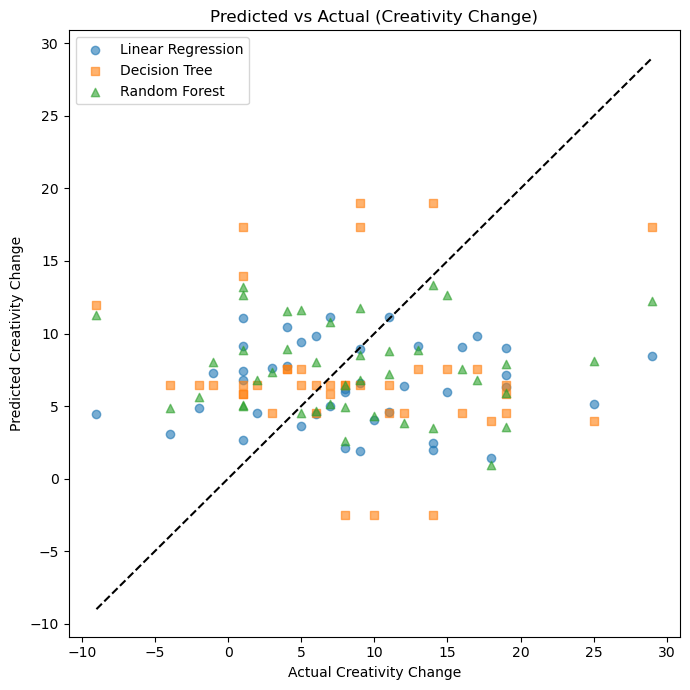


Random Forest feature importances:
           feature  importance
0         num__SPS      0.3642
1         num__CSE      0.3340
2         num__age      0.1600
3   cat__Group_1.0      0.0811
4  cat__gender_2.0      0.0608


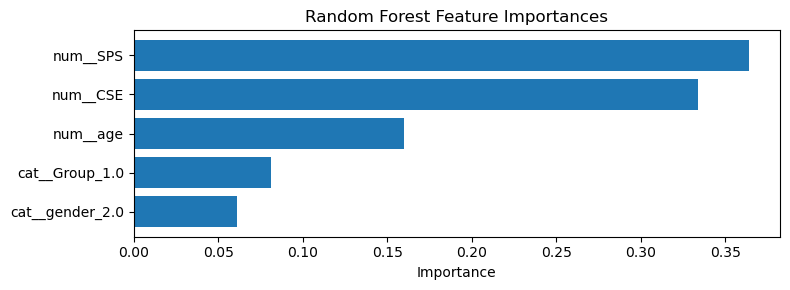

In [6]:
# Creativity change prediction: Linear / Decision Tree / Random Forest + Cross-validation
# -------------------------
# Helper: robust sklearn version parse + OneHotEncoder factory
# -------------------------
def parse_sklearn_major_minor(version_str):
    # Extract numeric major and minor like "1.2.3rc1" -> (1,2)
    parts = version_str.split(".")
    nums = []
    for p in parts[:2]:
        m = re.match(r"(\d+)", p)
        nums.append(int(m.group(1)) if m else 0)
    if len(nums) == 1:
        nums.append(0)
    return nums[0], nums[1]

def get_onehot_encoder():
    major, minor = parse_sklearn_major_minor(sklearn.__version__)
    if major > 1 or (major == 1 and minor >= 2):
        # sklearn >= 1.2
        return OneHotEncoder(drop='first', sparse_output=False)
    else:
        # sklearn < 1.2
        return OneHotEncoder(drop='first', sparse=False)

# -------------------------
# Step 0: (optional) quick check
# -------------------------
print("scikit-learn version:", sklearn.__version__)

# -------------------------
# Step 1: Data preparation
# -------------------------
# Assumes `df` exists in the environment and has columns:
# ['Stage1', 'Stage2', 'SPS', 'Group', 'CSE', 'gender', 'age', ...]
df_ml = df.dropna(subset=['Stage1', 'Stage2', 'SPS', 'Group', 'CSE', 'gender', 'age']).copy()
df_ml['CreativityChange'] = df_ml['Stage2'] - df_ml['Stage1']

X = df_ml[['SPS', 'Group', 'CSE', 'gender', 'age']]
y = df_ml['CreativityChange']

# -------------------------
# Step 2: Preprocessing
# -------------------------
categorical_cols = ['Group', 'gender']
numeric_cols = ['SPS', 'CSE', 'age']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', get_onehot_encoder(), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# -------------------------
# Step 3: Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# Step 4: Models to compare
# -------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=4, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
}

results = {}
trained_pipes = {}

# -------------------------
# Step 5: Train, evaluate, cross-validate
# -------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # fit on training set
    pipe.fit(X_train, y_train)
    trained_pipes[name] = pipe

    # test set metrics
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # cross-validated R2 (5-fold) on full data
    cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2')  # returns array of R2 per fold

    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R2_test': r2,
        'CV_R2_mean': np.mean(cv_scores),
        'CV_R2_std': np.std(cv_scores)
    }

# -------------------------
# Step 6: Print tabular results
# -------------------------
res_df = pd.DataFrame(results).T
# reorder / round for nicer display
res_df = res_df[['MSE', 'MAE', 'R2_test', 'CV_R2_mean', 'CV_R2_std']].round(4)
print("\nModel comparison (test metrics + 5-fold CV R2):")
print(res_df)

# also print per-model details
for name, stats in results.items():
    print(f"\n=== {name} ===")
    print(f"Test MSE: {stats['MSE']:.4f}")
    print(f"Test MAE: {stats['MAE']:.4f}")
    print(f"Test R²: {stats['R2_test']:.4f}")
    print(f"CV R² mean: {stats['CV_R2_mean']:.4f} (± {stats['CV_R2_std']:.4f})")

# -------------------------
# Step 7: Visualization - Predicted vs Actual (each model)
# -------------------------
plt.figure(figsize=(7,7))
markers = {'Linear Regression': 'o', 'Decision Tree': 's', 'Random Forest': '^'}
for name, pipe in trained_pipes.items():
    y_pred = pipe.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6, label=name, marker=markers.get(name, 'o'))

minv = min(y_test.min(), *(pipe.predict(X_test).min() for pipe in trained_pipes.values()))
maxv = max(y_test.max(), *(pipe.predict(X_test).max() for pipe in trained_pipes.values()))
plt.plot([minv, maxv], [minv, maxv], 'k--', lw=1.5)
plt.xlabel("Actual Creativity Change")
plt.ylabel("Predicted Creativity Change")
plt.title("Predicted vs Actual (Creativity Change)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Step 8: Feature importance for Random Forest (if possible)
# -------------------------
if 'Random Forest' in trained_pipes:
    rf_pipe = trained_pipes['Random Forest']
    rf_model = rf_pipe.named_steps['model']
    pre_fitted = rf_pipe.named_steps['preprocessor']
    try:
        # get feature names if available (sklearn >= 1.0 typically supports get_feature_names_out)
        feature_names = pre_fitted.get_feature_names_out()
    except Exception:
        feature_names = None

    if feature_names is not None and hasattr(rf_model, "feature_importances_"):
        fi = rf_model.feature_importances_
        fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi})
        fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
        print("\nRandom Forest feature importances:")
        print(fi_df.round(4))
        # quick bar plot
        plt.figure(figsize=(8, max(3, 0.35 * len(fi_df))))
        plt.barh(fi_df['feature'][::-1], fi_df['importance'][::-1])
        plt.xlabel("Importance")
        plt.title("Random Forest Feature Importances")
        plt.tight_layout()
        plt.show()
    else:
        print("\nUnable to retrieve the preprocessed feature names (get_feature_names_out is unavailable), so the feature importance display is skipped.")


# Analysis of Creativity Change Prediction

## 1. Model Performance
- **Linear Regression** performed slightly better than others (Test R² ≈ -0.17, CV R² ≈ -0.03), but all models show negative R², indicating very limited predictive power.  
- **Decision Tree** and **Random Forest** performed worse, suggesting overfitting on noise in the current dataset.  
- Overall, the selected features (SPS, CSE, age, gender, group) explain little of the variance in creativity change under stress.

## 2. Feature Importance (Random Forest)
| Feature | Importance |
|---------|------------|
| SPS | 36% |
| CSE | 33% |
| Age | 16% |
| Group | 8% |
| Gender | 6% |

- **SPS** and **CSE** are the most influential predictors, but alone they do not provide strong predictive power.  
- Age has moderate influence, while group assignment and gender contribute minimally.

## 3. Interpretation
- Creativity change under stress is **poorly captured by the current features**, implying that other factors (e.g., situational variables, emotional state, motivation) may play a larger role.  
- SPS and CSE may still be important **psychological factors** for further study, potentially in interaction with other variables.  
- Future work could explore **feature interactions, additional predictors, or non-linear models** to improve prediction accuracy.


Running SHAP TreeExplainer for Random Forest...

Random Forest SHAP Feature Importance (bar)


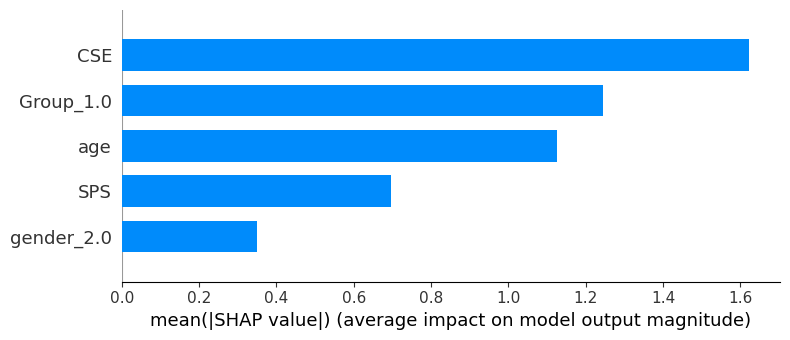


Random Forest SHAP Summary Plot (dot)


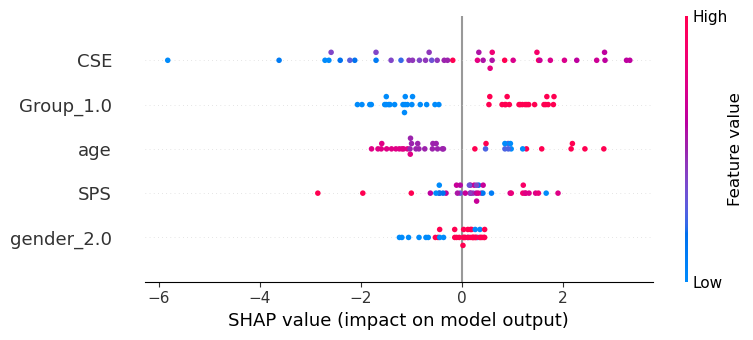


Random Forest SHAP dependence plot for feature: CSE


<Figure size 2000x1500 with 0 Axes>

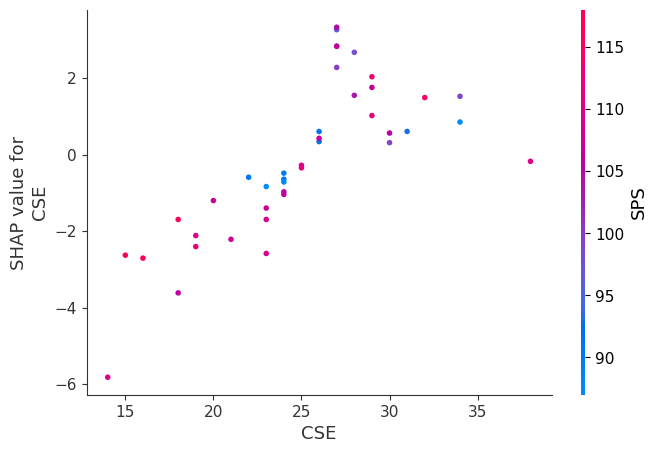


Random Forest SHAP dependence plot for feature: Group_1.0


<Figure size 2000x1500 with 0 Axes>

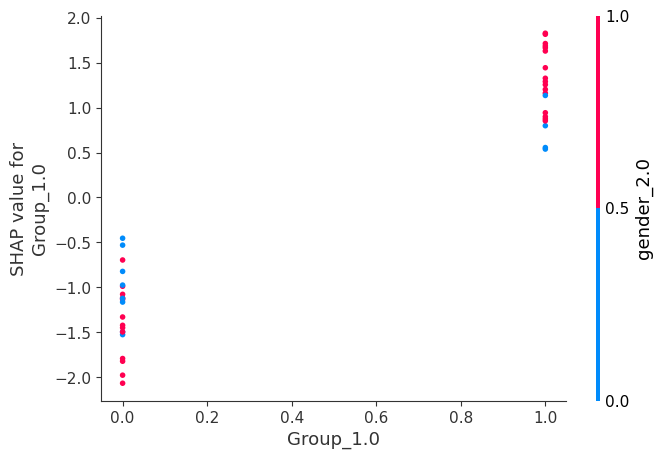


Random Forest SHAP dependence plot for feature: age


<Figure size 2000x1500 with 0 Axes>

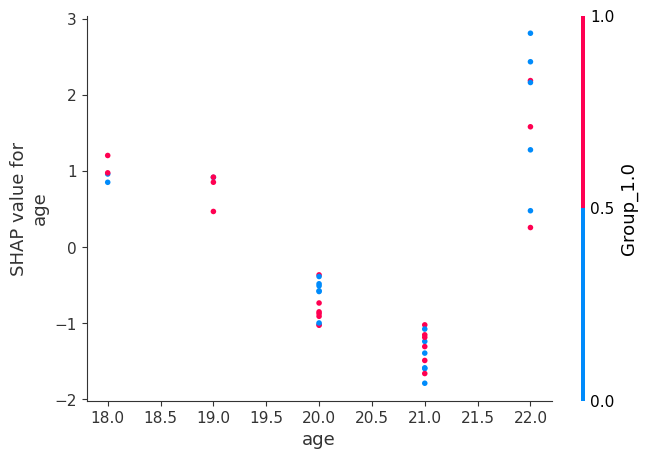


Running SHAP LinearExplainer for Linear Regression...

Linear Regression SHAP Feature Importance (bar)


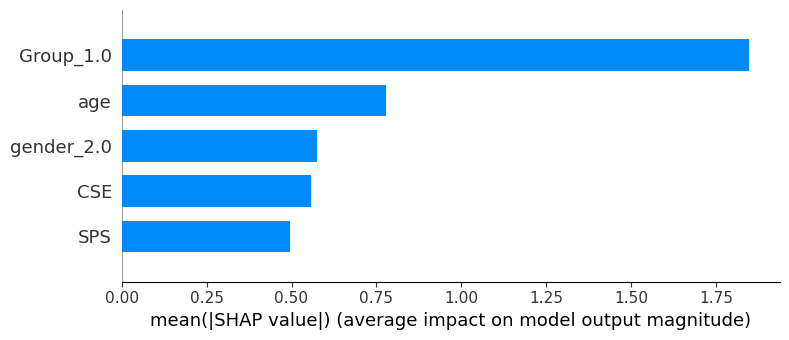


Linear Regression SHAP Summary Plot (dot)


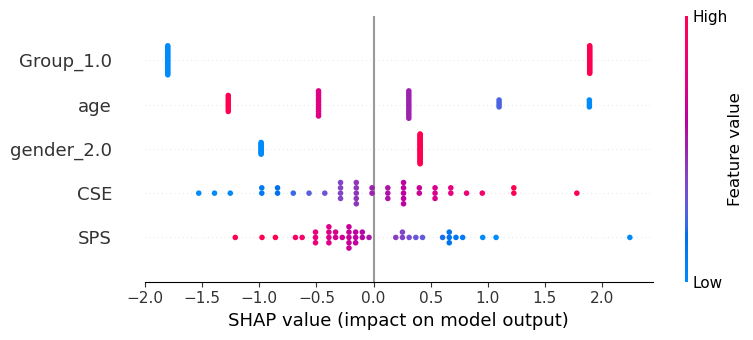


Linear Regression SHAP dependence plot for feature: Group_1.0


<Figure size 2000x1500 with 0 Axes>

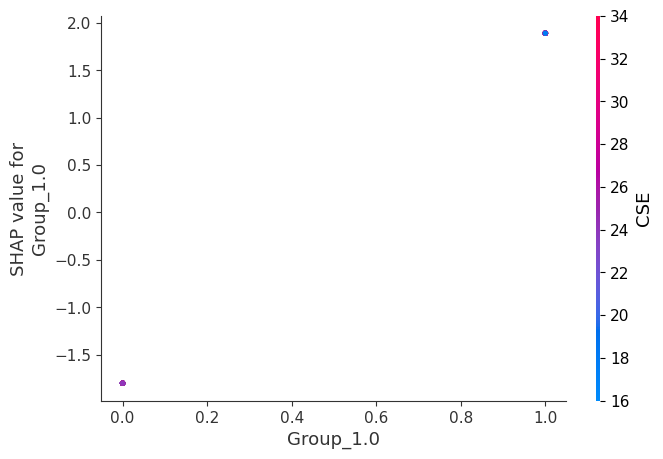


Linear Regression SHAP dependence plot for feature: age


<Figure size 2000x1500 with 0 Axes>

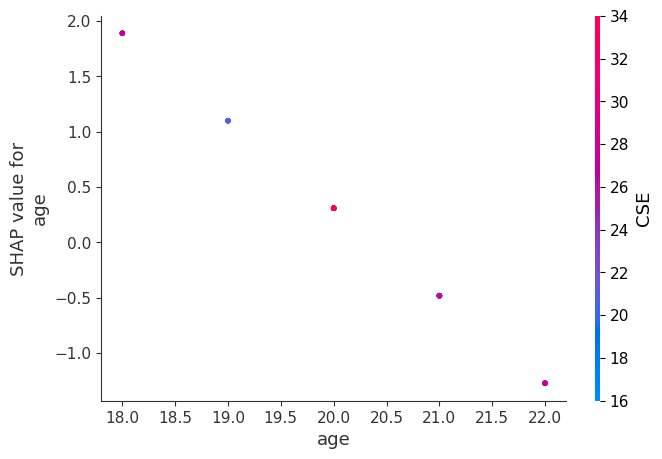


Linear Regression SHAP dependence plot for feature: gender_2.0


<Figure size 2000x1500 with 0 Axes>

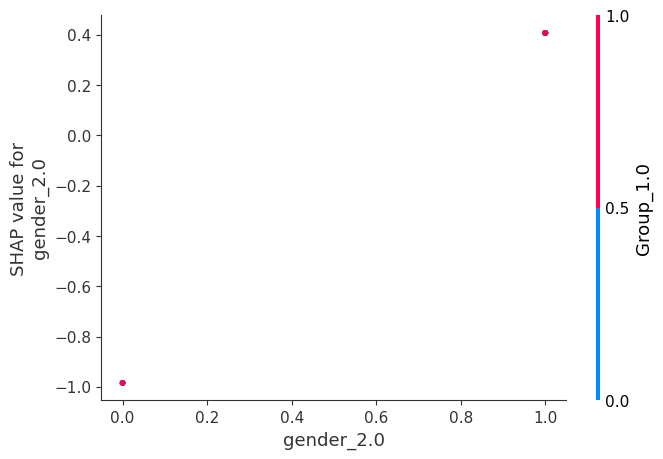

In [7]:
# -------------------------
# Helper 1: sklearn version parse + OneHotEncoder factory
# -------------------------
def parse_sklearn_major_minor(version_str):
    parts = version_str.split(".")
    nums = []
    for p in parts[:2]:
        m = re.match(r"(\d+)", p)
        nums.append(int(m.group(1)) if m else 0)
    if len(nums) == 1:
        nums.append(0)
    return nums[0], nums[1]

def get_onehot_encoder():
    major, minor = parse_sklearn_major_minor(sklearn.__version__)
    if major > 1 or (major == 1 and minor >= 2):
        return OneHotEncoder(drop='first', sparse_output=False)
    else:
        return OneHotEncoder(drop='first', sparse=False)

# -------------------------
# Helper 2: extract feature names
# -------------------------
def get_feature_names_from_preprocessor(preprocessor, numeric_cols, categorical_cols):
    """
    Extract feature names from a fitted ColumnTransformer.
    """
    feature_names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            try:
                fn = list(trans.get_feature_names_out(cols))
            except TypeError:
                fn = list(trans.get_feature_names_out())
            feature_names.extend(fn)
        elif cols is not None:
            feature_names.extend(cols)
    return feature_names


# -------------------------
# Full-screen helper
# -------------------------
plt.ion()  # interactive mode

def maximize_fig():
    """Maximize current figure (Windows / cross-platform)"""
    try:
        mng = plt.get_current_fig_manager()
        mng.window.showMaximized()
    except Exception:
        try:
            mng = plt.get_current_fig_manager()
            mng.full_screen_toggle()
        except Exception:
            pass


# -------------------------
# Random Forest SHAP
# -------------------------
if 'Random Forest' in trained_pipes:
    rf_pipe = trained_pipes['Random Forest']
    rf_model = rf_pipe.named_steps['model']
    rf_pre = rf_pipe.named_steps['preprocessor']

    X_test_trans = rf_pre.transform(X_test)
    feature_names = get_feature_names_from_preprocessor(rf_pre, numeric_cols, categorical_cols)
    if feature_names is None or len(feature_names) != X_test_trans.shape[1]:
        feature_names = [f"f{i}" for i in range(X_test_trans.shape[1])]
    X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

    print("\nRunning SHAP TreeExplainer for Random Forest...")
    explainer_rf = shap.TreeExplainer(rf_model)
    shap_values_rf = explainer_rf.shap_values(X_test_trans_df)

    # 1️⃣ Random Forest SHAP bar plot
    plt.figure(figsize=(20, 15))
    maximize_fig()
    print("\nRandom Forest SHAP Feature Importance (bar)")
    shap.summary_plot(shap_values_rf, X_test_trans_df, plot_type="bar", show=True)

    # 2️⃣ Random Forest SHAP summary plot
    plt.figure(figsize=(20, 15))
    maximize_fig()
    print("\nRandom Forest SHAP Summary Plot (dot)")
    shap.summary_plot(shap_values_rf, X_test_trans_df, show=True)

    # 3️⃣ Top 3 Random Forest SHAP dependence plots
    mean_abs_shap = np.mean(np.abs(shap_values_rf), axis=0)
    top_idx = np.argsort(mean_abs_shap)[-3:][::-1]
    top_features = [feature_names[i] for i in top_idx]

    for feat in top_features:
        plt.figure(figsize=(20, 15))
        maximize_fig()
        print(f"\nRandom Forest SHAP dependence plot for feature: {feat}")
        shap.dependence_plot(feat, shap_values_rf, X_test_trans_df, show=True)
else:
    print("Random Forest pipeline not found; skipping SHAP analysis.")


# -------------------------
# Linear Regression SHAP
# -------------------------
if 'Linear Regression' in trained_pipes:
    lr_pipe = trained_pipes['Linear Regression']
    lr_model = lr_pipe.named_steps['model']
    lr_pre = lr_pipe.named_steps['preprocessor']
    
    X_test_trans_lr = lr_pre.transform(X_test)
    feature_names_lr = get_feature_names_from_preprocessor(lr_pre, numeric_cols, categorical_cols)
    if feature_names_lr is None or len(feature_names_lr) != X_test_trans_lr.shape[1]:
        feature_names_lr = [f"f{i}" for i in range(X_test_trans_lr.shape[1])]
    X_test_trans_lr_df = pd.DataFrame(X_test_trans_lr, columns=feature_names_lr)

    print("\nRunning SHAP LinearExplainer for Linear Regression...")
    try:
        explainer_lr = shap.LinearExplainer(lr_model, X_test_trans_lr_df, feature_perturbation="interventional")
    except Exception:
        explainer_lr = shap.LinearExplainer(lr_model, X_test_trans_lr_df.values, feature_perturbation="interventional")
    shap_values_lr = explainer_lr.shap_values(X_test_trans_lr_df)

    # 1️⃣ Linear Regression SHAP bar plot
    plt.figure(figsize=(20, 15))
    maximize_fig()
    print("\nLinear Regression SHAP Feature Importance (bar)")
    shap.summary_plot(shap_values_lr, X_test_trans_lr_df, plot_type="bar", show=True)

    # 2️⃣ Linear Regression SHAP summary plot
    plt.figure(figsize=(20, 15))
    maximize_fig()
    print("\nLinear Regression SHAP Summary Plot (dot)")
    shap.summary_plot(shap_values_lr, X_test_trans_lr_df, show=True)

    # 3️⃣ Top 3 Linear Regression SHAP dependence plots
    mean_abs_shap_lr = np.mean(np.abs(shap_values_lr), axis=0)
    top_idx_lr = np.argsort(mean_abs_shap_lr)[-3:][::-1]
    top_features_lr = [feature_names_lr[i] for i in top_idx_lr]

    for feat in top_features_lr:
        plt.figure(figsize=(20, 15))
        maximize_fig()
        print(f"\nLinear Regression SHAP dependence plot for feature: {feat}")
        shap.dependence_plot(feat, shap_values_lr, X_test_trans_lr_df, show=True)
else:
    print("Linear Regression pipeline not found; skipping SHAP analysis.")


## SHAP Analysis Summary

**1. Random Forest Model**
- **Key Feature:** `num_CSE` has the highest mean absolute SHAP value, indicating the strongest influence on predicted creativity change.  
- **Secondary Features:** `cat_Group_1.0`, `num_age`, `num_SPS` show moderate contributions.  
- **Minor Feature:** `cat_gender_2.0` has minimal impact.  
- **Feature Effects:** Positive correlation observed for `num_CSE` (higher values increase predictions). Interaction effects exist between `num_CSE` & `num_SPS` and between `cat_Group_1.0` & `cat_gender_2.0`.

**2. Linear Regression Model**
- **Key Feature:** `cat_Group_1.0` is the most important feature, with the largest SHAP impact.  
- **Secondary Features:** `num_age`, `cat_gender_2.0`, `num_CSE` contribute moderately.  
- **Minor Feature:** `num_SPS` has minimal influence.  
- **Feature Effects:** Linear effects dominate, with `cat_Group_1.0` strongly influencing predictions.

**3. Comparative Insights**
- **Model-Specific Feature Importance:** Random Forest captures non-linear relationships (`num_CSE` dominant), while Linear Regression emphasizes linear effects (`cat_Group_1.0` dominant).  
- **Secondary Features:** `num_age` has moderate impact across models; `cat_gender_2.0` and `num_SPS` are less influential.  


# Executive Summary

Current analyses combining unsupervised clustering and supervised modeling indicate that **SPS and CSE are relevant but insufficient predictors of creativity change under stress**, with gender influencing cluster patterns but having limited effect in predictive models. Random Forest highlights non-linear effects (CSE dominant), while Linear Regression emphasizes linear contributions (Group dominant). Overall, predictive power is low (negative/near-zero R²), suggesting that creativity under stress is influenced by additional factors such as situational context, emotional state, and latent individual traits. **Future research** should incorporate richer psychological and environmental features, explore non-linear and ensemble models, model feature interactions, and leverage longitudinal or repeated measures to better understand and predict creativity resilience.
